# Denoising Autoencoders

In this exercise, we would like to train on the MNIST dataset a denoising auto-encoder made one layer of ReLU nonlinearity. Once the auto-encoder is implemented and trained, the reconstruction error, the sparsity of the solution and the parameters of the model will be analyzed.

The next few lines of code load the necessary Python modules for this exercise sheet, and read the MNIST dataset from scikit-learn. Since the autoencoders are unsupervised models, only the input MNIST data is necessary. The input data is normalized to have mean zero and standard deviation one.

In [1]:
# Load libraries
import numpy
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_mldata

# Extract MNIST data
mnist = fetch_mldata('MNIST original')
X = mnist['data']
X = X - X.mean()
X = X / X.std()

The MNIST data consists of 70000 handwritten digits of 28x28 pixels, stored in a matrix `X` of size 70000x784. The following code displays in a mosaic format 100 randomly selected MNIST digits. This visualization is obtained by successive reshapings and transpositions of the input matrix.

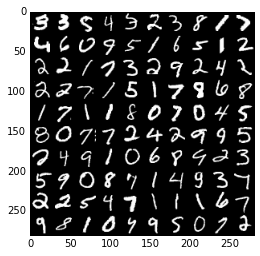

In [2]:
R = numpy.random.randint(0,70000,[100])
plt.imshow(X[R].reshape(10,10,28,28).transpose(0,2,1,3).reshape(10*28,10*28),cmap='gray')
plt.show()

As it can be observed, the MNIST dataset is composed of handwritten digits from 0 to 9 with varying writing styles. Modeling these digits (e.g. predicting their labels, estimating their distribution, or removing noise added to them) is a non-trivial task for which one needs machine learning.

## Implementing an auto-encoder (20 P)

We consider a simple two-layer denoising autoencoder where given an input `x` representing a digit to which noise has been added, it produces a reconstruction `y`, that should be as close as possible to the original digit (i.e. a denoised version of `x`). The auto-encoder can be depicted as follow:

![](autoencoder.png)

The code below defines a class `AutoEncoder` that provides the functionalities for storing the model parameters, performing the reconstruction, and training the model. It consists of four methods:

* The method `__init__(self)` initializes the parameters of the autoencoder to some random values of distributions selected heuristically.

* The method `forward(self,x)` applies to a noisy input `x` a forward pass on the autoencoder and outputs the denoised reconstruction of that input.

* The method `backward(self,dEdy)` receives as input the error gradient with respect to the autoencoder output `dEdy`, and outputs the error gradient with respect to the parameters of the network.

* The method `update(self,lr)` performs a gradient step with a certain learning rate `lr` based on the gradient computation obtained in the `backward` method.

In [3]:
class AutoEncoder:
    def __init__(self, nbinput, nbhid):
        self.W = numpy.random.normal(0, 0.01, [nbinput, nbhid])
        self.B = numpy.zeros([nbhid]) + 0.5
        self.V = numpy.random.normal(0, 0.01, [nbhid, nbinput])
        self.C = numpy.zeros([nbinput])
        
    def forward(self, x):
        self.x = x
        h = numpy.dot(x, self.W) + self.B
        self.z = numpy.maximum(0, h)
        y = numpy.dot(self.z, self.V) + self.C
        return y
    
    def backward(self, dEdy):
        self.dEdC = 2 * dEdy
        self.dEdV = numpy.dot(self.z.reshape(self.z.shape[0], 1),
                              self.dEdC.reshape(1, self.dEdC.shape[0]))

        z_prime = self.z > 0
        self.dEdB = 2 * (dEdy * self.V).sum(axis=1)
        self.dEdW = numpy.dot(self.x.reshape(self.x.shape[0], 1),
                              self.dEdB.reshape(1, self.dEdB.shape[0]))
        self.dEdB *= z_prime
        self.dEdW *= z_prime
        
    def update(self,lr):
        self.V = self.V - lr*self.dEdV
        self.W = self.W - lr*self.dEdW
        self.C = self.C - lr*self.dEdC
        self.B = self.B - lr*self.dEdB

The code below trains the denoising autoencoder for 25000 iterations using stochastic gradient descent, and a Gaussian noise of scale 1.0 on each dimension of the input digit. The objective to minimize is the squared Euclidean norm between the autoencoder output and the original digit (without noise).

* **Implement the method `backward(self,dEdy)` of the class `AutoEncoder`.**
* **Run the code below to train the autoencoder.**

Training an autoencoder can take a long time. You may want to reduce the number of training steps `nbit` during the development phase, and set it back to the original value afterwards. The training procedure keeps track of the error at each iteration on the current example and stores it in an array `err`. It also keeps track of the sparsity in the hidden layer (measured as the fraction of non-zero activations) and store these values in an array `spar`. Finally, the code plots the evolution of the error at each iteration.

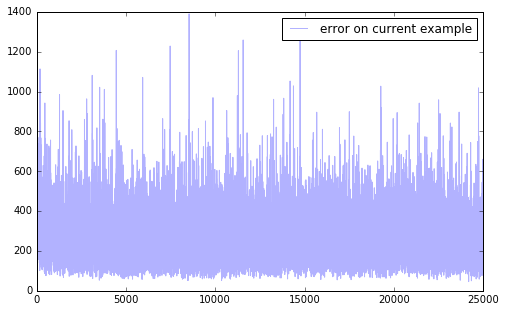

In [4]:
ae = AutoEncoder(784,225)

err  = [] # error at each iteration
spar = [] # sparsity at each iteration

nbit = 25000

for i in range(1, nbit + 1):
    
    # Choose a random data point
    x0 = X[numpy.random.randint(70000)]
    
    # Train the autoencoder with this data point
    x = x0 + numpy.random.normal(0, 1.0, x0.shape)
    y = ae.forward(x)
    ae.backward(y - x0)
    ae.update(0.0005)
    
    # Keep track of the reconstruction error and sparsity
    err  += [((y - x0)**2).sum()]
    spar += [(ae.z > 0).sum() * 1.0 / len(ae.z)]

# Plot reconstruction error over time
plt.figure(figsize=(8, 5))
plt.plot(err, alpha=0.3, label='error on current example')
plt.legend(loc='upper right')
plt.show()

## Smoothing the plot and tracking sparsity (10 P)

In the plot above, examples in successive iterations have highly varying reconstruction errors. Instead, we would like to measure some average of the error over a set of consecutive examples.

* **Apply a moving average of 25 iterations, and superpose to the original error curve the resulting smoothed error curve.**
* **Produce a similar plot for visualizing the evolution of hidden layer sparsity over time.**

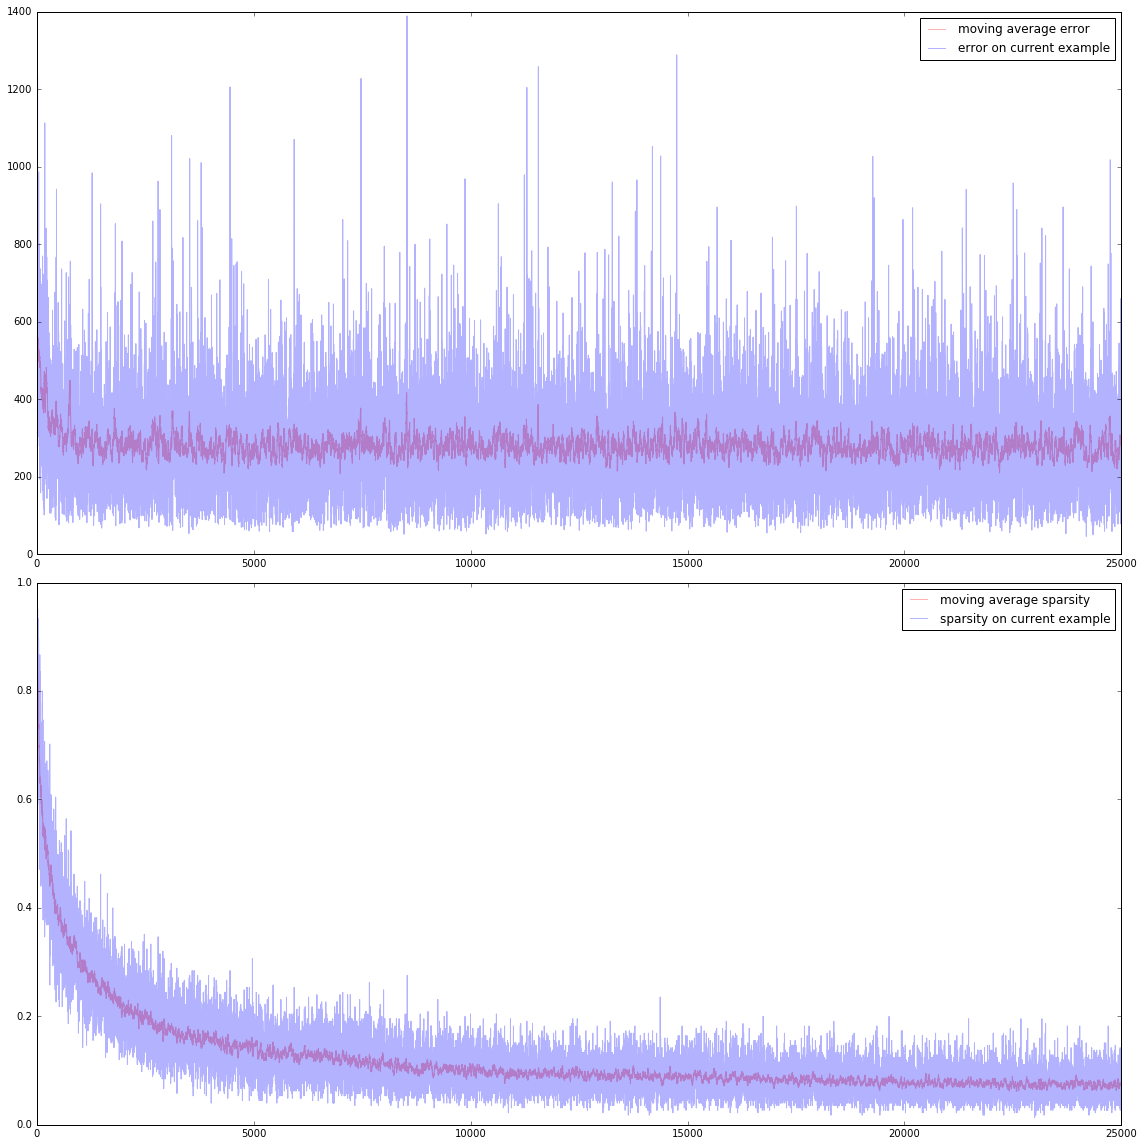

In [6]:
def moving_average(a, n=3):
    ret = numpy.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

f, axes = plt.subplots(2, 1, figsize=(16, 16))

axes[0].plot(moving_average(err, n=25), alpha=0.3, label='moving average error', c='r')
axes[0].plot(err, alpha=0.3, label='error on current example', c='b')
axes[0].legend(loc='upper right')

axes[1].plot(moving_average(spar, n=25), alpha=0.3, label='moving average sparsity', c='r')
axes[1].plot(spar, alpha=0.3, label='sparsity on current example', c='b')
axes[1].legend(loc='upper right')
#solution.plotspar(spar)
f.tight_layout()

## Displaying model parameters (10 P)

In addition to measuring the prediction error, it is often useful to visualize what hidden neurons are representing in the pixel space. For each hidden layer neuron, there are 784 first-layer weights that are connected to it, and they can be visualized as a pixel image. The following code shows these images for all 225 hidden neurons. All 28x28 images are displayed in a mosaic of 15x15 tiles, by application of a series of reshaping and transposition operations.

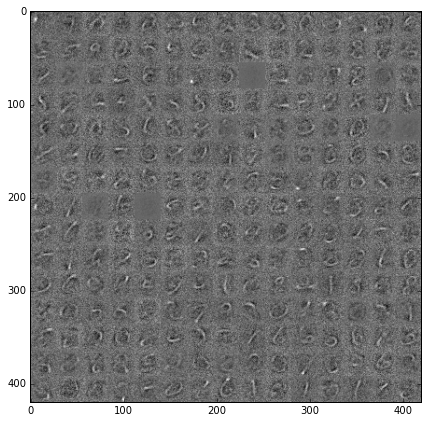

In [7]:
plt.figure(figsize=(7,7))
plt.imshow(ae.W.reshape(28,28,15,15).transpose(2,0,3,1).reshape(28*15,28*15),cmap='gray')
plt.show()

* **Implement a similar visualization for the second-layer weights `V`, where each image of the mosaic is composed of the parameter connecting a given neuron to all output dimensions of the autoencoder.**
* **Describe what kind of features the weights `W` and `V` model on this dataset, and how the two sets of features relate to each other.**

**ANSWER:**

`W` seems to be modeling both the noise-contaminated features from the original images, whereas `V` seems to model the noise-free versions of the same.
A possibility is that the ReLu activation is the responsible of cleaning the images.
If this is the case, without noise `W` and `V` should look like transposed versions of each other.

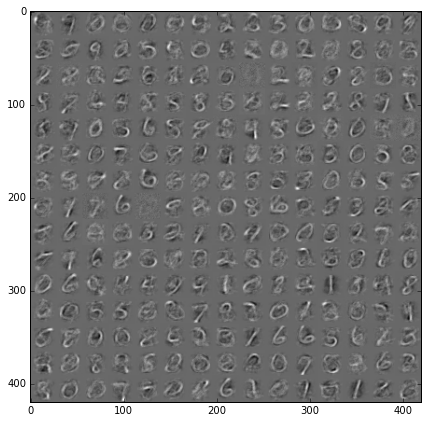

In [8]:
plt.figure(figsize=(7,7))
tiles = ae.V.reshape(15, 15, 28, 28).transpose(0, 2, 1, 3)
tiles = tiles.reshape(28*15, 28*15)
plt.imshow(tiles, cmap='gray')
plt.show()

## Displaying reconstructions of data points (10 P)

As a last analysis, we can verify that the noise was properly added to the input digit and that the autoencoder correctly performs denoising of the input digit.

* **Show for 10 randomly selected MNIST digits: the original digit (top), the same digit with additive noise that we give as input to the autoencoder (middle), and the reconstructed digit at the output of the autoencoder (bottom).**

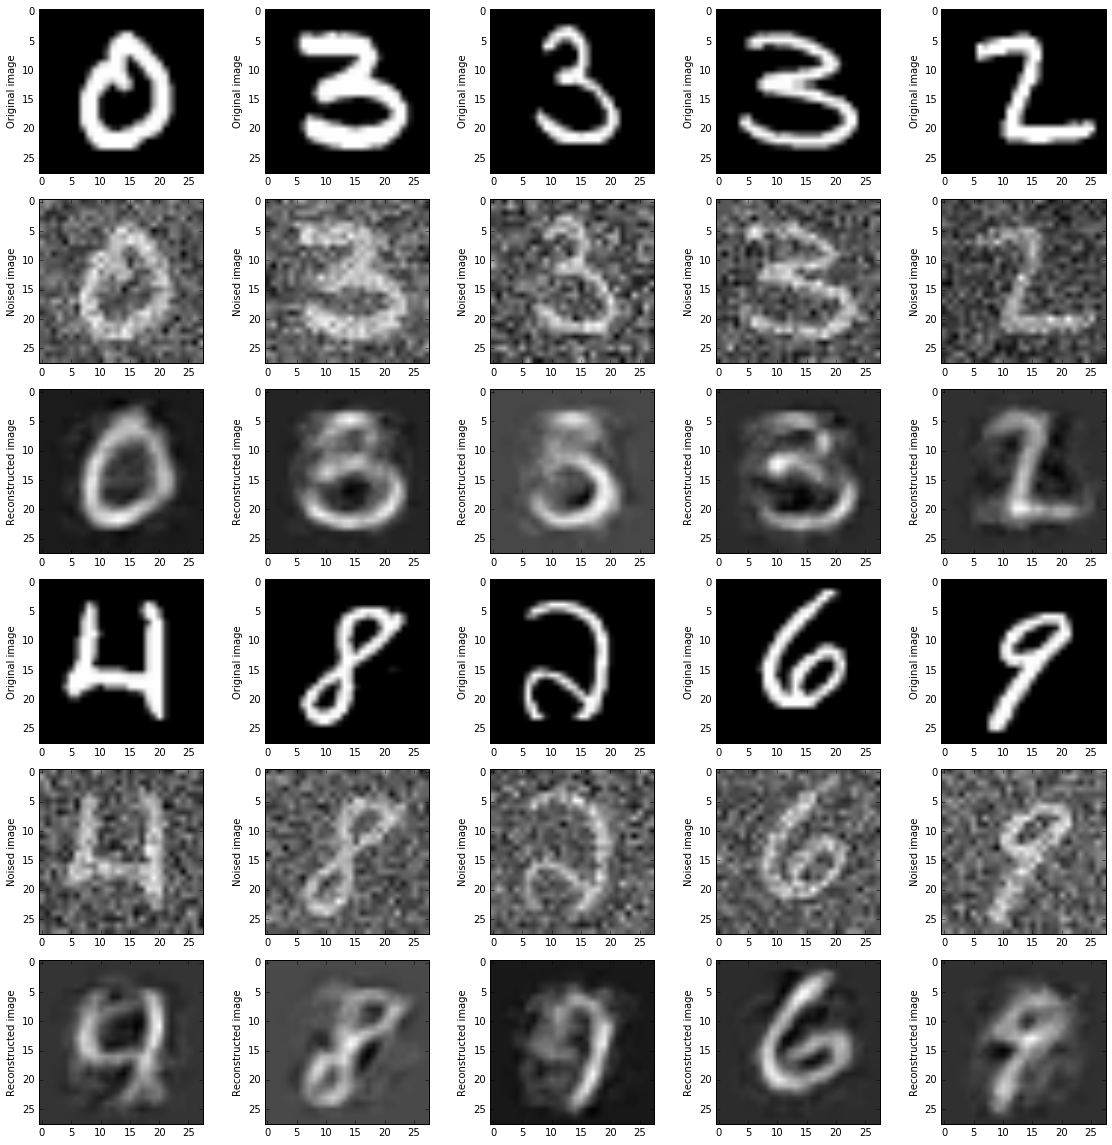

In [9]:
def plot_tiles(axes, tiles, from_idx, to_idx, offset=0):
    for i in range(from_idx, to_idx):
        normal = tiles[i].reshape(28, 28)
        noised = tiles[i] + numpy.random.normal(0, 1.0, tiles[i].shape)
        predicted = ae.forward(noised).reshape(28, 28)
        noised = noised.reshape(28, 28)
        ax1 = axes[0+offset, i]
        ax2 = axes[1+offset, i]
        ax3 = axes[2+offset, i]
        ax1.imshow(normal, cmap='gray')
        ax1.set_aspect('equal')
        ax1.set_ylabel('Original image')
        ax2.imshow(noised, cmap='gray')
        ax2.set_aspect('equal')
        ax2.set_ylabel('Noised image')
        ax3.imshow(predicted, cmap='gray')
        ax3.set_aspect('equal')
        ax3.set_ylabel('Reconstructed image')

indexes = numpy.random.randint(0, len(X), 10)
tiles = X[indexes]

f, axes = plt.subplots(6, 5, figsize=(16, 16))
plot_tiles(axes, tiles, 0, 5)
plot_tiles(axes, tiles[5:], 0, 5, 3)
f.tight_layout()